In [471]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import anndata as ad
from muon import prot as pt
import squidpy as sq
import scanpy as sc

In [472]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData
li.__version__

'1.0.0a0'

In [473]:
from pybiomart import Dataset

In [474]:
# from https://www.hcdm.org/index.php/molecule-information
cd_to_ncbi = pd.read_csv("CD_to_ncbi.txt", sep="\t", header=None, names=["CD_NAME", "NCBI_NAME", "GENE_NAME", "NCBI_OTHER_NAME"])
cd_to_ncbi.NCBI_OTHER_NAME = [str(s).split(";") for s in cd_to_ncbi.NCBI_OTHER_NAME]
cd_to_ncbi

,CD_NAME,NCBI_NAME,GENE_NAME,NCBI_OTHER_NAME
0,CD1a,CD1A,CD1A,[CD1]
1,CD1b,CD1B,CD1B,[CD1]
2,CD1c,CD1C,CD1C,[CD1]
3,CD1d,CD1D,CD1D,[none]
4,CD1e,CD1E,CD1E,[HSCDIEL]
...,...,...,...,...
412,CD367,CLEC4A,CD367,"[DCIR, DDB27, CLECSF6]"
413,CD368,CLEC4D,CD368,"[MCL, CLECSF8, CLEC-6, MPCL]"
414,CD369,CLEC7A,CD369,"[DECTIN-1, CLECSF12,]"
415,CD370,CLEC9A,CD370,"[HEEE9341, UNQ9341, DNGR1]"


In [272]:
dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(dataset.list_attributes())
# or check attributes here: https://www.ensembl.org/biomart/martview

In [273]:
gene_annot = dataset.query(attributes=["ensembl_gene_id", "external_gene_name", "hgnc_symbol", "uniprot_gn_symbol", "wikigene_name"])
gene_annot

,Gene stable ID,Gene name,HGNC symbol,UniProtKB Gene Name symbol,WikiGene name
0,ENSG00000210049,MT-TF,MT-TF,NaN,NaN
1,ENSG00000211459,MT-RNR1,MT-RNR1,NaN,NaN
2,ENSG00000210077,MT-TV,MT-TV,NaN,NaN
3,ENSG00000210082,MT-RNR2,MT-RNR2,NaN,NaN
4,ENSG00000209082,MT-TL1,MT-TL1,NaN,NaN
...,...,...,...,...,...
77287,ENSG00000236500,CD24P1,CD24P1,NaN,NaN
77288,ENSG00000197312,DDI2,DDI2,DDI2,DDI2
77289,ENSG00000215695,RSC1A1,RSC1A1,RSC1A1,RSC1A1
77290,ENSG00000271742,NaN,NaN,NaN,NaN


In [274]:
gene_annot_2 = dataset.query(attributes=["ensembl_gene_id", "external_gene_name", "hgnc_id"])
hgnc = pd.read_csv("group-471.csv", skiprows=1).rename(columns={'HGNC ID (gene)':'HGNC ID'})
gene_annot_2 = gene_annot_2.set_index("HGNC ID").join(hgnc, how="left")
gene_annot_2

,Gene stable ID,Gene name,HGNC ID,Approved symbol,Approved name,Previous symbols,Aliases,Chromosome
HGNC ID,,,,,,,,
HGNC:100,ENSG00000110881,ASIC1,NaN,NaN,NaN,NaN,NaN,NaN
HGNC:10000,ENSG00000117152,RGS4,NaN,NaN,NaN,NaN,NaN,NaN
HGNC:10001,ENSG00000143248,RGS5,NaN,NaN,NaN,NaN,NaN,NaN
HGNC:10002,ENSG00000182732,RGS6,NaN,NaN,NaN,NaN,NaN,NaN
HGNC:10003,ENSG00000182901,RGS7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
NaN,ENSG00000286198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,ENSG00000226843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,ENSG00000272510,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
rna_path = "/Users/pschafer/Liana_Vignette/data/GSE213264/GSM6578062_humantonsil_RNA.tsv.gz"
prot_path = "/Users/pschafer/Liana_Vignette/data/GSE213264/GSM6578071_humantonsil_protein.tsv.gz"
ab_path = "/Users/pschafer/Liana_Vignette/data/41587_2023_1676_MOESM3_ESM.xlsx"

In [67]:
# sheets: HUMAN_273, MOUSE_189
ab_df = pd.read_excel(ab_path, sheet_name="HUMAN_273")

In [68]:
rna = pd.read_csv(rna_path, sep="\t")
prot = pd.read_csv(prot_path, sep="\t")
assert set(rna.X) == set(prot.X)

rna = rna.set_index("X")
prot = prot.set_index("X")
prot = prot.loc[rna.index]
assert np.all(rna.index == prot.index)

In [69]:
# get coordinates
def get_coord(col):
    x_coord = [s.split("x")[0] for s in col]
    y_coord = [s.split("x")[1] for s in col]
    df_coord = pd.DataFrame({"x": x_coord, "y": y_coord})
    df_coord = df_coord.apply(pd.to_numeric)
    return df_coord
coord = get_coord(rna.index)

In [70]:
# remove spike ins from rna
print(rna.shape)
spike_bool = np.array(["ERCC" in c for c in rna.columns])
print(spike_bool.sum())
rna = rna.loc[:,~spike_bool]
print(rna.shape)

(2492, 28417)
29
(2492, 28388)


In [72]:
# TODO: remove unmapped from protein?
print(prot.shape)
unmapped_bool = np.array(["unmapped" in c for c in prot.columns])
print(unmapped_bool.sum())
prot = prot.loc[:,~unmapped_bool]
print(prot.shape)

(2492, 283)
1
(2492, 282)


In [73]:
# clean protein names
clean_names = prot.columns
clean_names = [re.sub("\\.[AGCT]{15}", "", s) for s in prot.columns]
clean_names = [re.sub("anti\\.mouse\\.human", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.human\\.mouse", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.mouse\\.rat\\.human", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.mouse\\.rat", "", s) for s in clean_names]
clean_names = [re.sub("Mouse", "", s) for s in clean_names]
clean_names = [re.sub("Rat", "", s) for s in clean_names]
clean_names = [re.sub("Human", "", s) for s in clean_names]
clean_names = [re.sub("isotype\\.Ctrl", "", s) for s in clean_names]
clean_names = [re.sub("Isotype\\.Ctrl", "", s) for s in clean_names]
clean_names = [re.sub("\\.\\.k", "", s) for s in clean_names]
clean_names = [re.sub("\\.+$", "", s) for s in clean_names]
clean_names = [re.sub("^\\.+", "", s) for s in clean_names]

In [424]:
# merge from barcode excel sheet
barcodes = np.array([re.search("[AGCT]{15}|unmapped", s).group() for s in prot.columns])
barcodes = pd.DataFrame({"barcode": barcodes}).join(ab_df.set_index("Barcode"), on="barcode")
barcodes["Clean"] = clean_names
#barcodes["Target"] = [re.sub("anti-human ", "", str(s)) for s in barcodes["Target"].to_numpy()]
#barcodes["Target"] = [re.sub("anti-human/mouse ", "", str(s)) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-human ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-human/mouse ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-mouse/human ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("Recombinant", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-Human", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [s.strip() for s in barcodes["Target"].to_numpy()]

# extract all names in the bracket in s and put into a list
def extract_names(s):
    pattern = re.compile(r'\((.*?)\)')
    return pattern.findall(s)

# remove the bracket in s and put into a list
def remove_bracket(s):
    pattern = re.compile(r' \((.*?)\)')
    return pattern.sub('', s)

primary_names = []
alternative_names = []
for bc, target in zip(barcodes.barcode, barcodes.Target):
    primary_names.append(remove_bracket(target))
    alternative_names.append(extract_names(target))

barcodes["Primary"] = [s.strip() for s in primary_names]
barcodes["Alternative"] = alternative_names
barcodes = barcodes.set_index("Primary").join(cd_to_ncbi.set_index("CD_NAME"), how="left")
barcodes = barcodes.reset_index().rename(columns={"index": "Primary"})
barcodes = barcodes.fillna("none")
barcodes

,Primary,barcode,DNA_ID,Target,Clean,Alternative,NCBI_NAME,GENE_NAME,NCBI_OTHER_NAME
0,CD64,AAGTATGCCCTACGA,A0162,CD64,CD64,[],none,none,none
1,CD1d,TCGAGTCGCTTATCA,A0164,CD1d,CD1d,[],CD1D,CD1D,[none]
2,CD270,TGATAGAAACAGACC,A0020,"CD270 (HVEM, TR2)",CD270..HVEM_.TR2,"[HVEM, TR2]",TNFRSF14,CD270,"[ATAR, CD270, ""herpesvirus entry mediator"", ..."
3,CD319,AGTATGCCATGTCTT,A0830,CD319 (CRACC),CD319..CRACC,[CRACC],SLAMF7,CD319,"[19A, CRACC, CS1]"
4,CD34,GCAGAAATCTCCCTT,A0054,CD34,CD34,[],CD34,CD34,[none]
...,...,...,...,...,...,...,...,...,...
277,CD37,ACAGTCACTGGGCAA,A0941,CD37,CD37,[],CD37,CD37,[GP52-40]
278,TNF-α,CCTATGAACGTAACG,A0945,TNF-α,TNF.a,[],none,none,none
279,CD215,CATATTCCGCCGTAA,A0947,CD215 (IL-15Rα),CD215..IL.15Ra,[IL-15Rα],IL15RA,CD215,"[CD215, IL-15RA]"
280,CD321,GACAGTACCGACACT,A0948,CD321,CD321,[],F11R,CD321,"[JAM, KAT, JAM1, JCAM, JAM-1, PAM-1]"


In [504]:
db = li.rs.select_resource("consensus")
ligands_orig = np.unique(db.ligand.to_numpy())
receptors_orig = np.unique(db.receptor.to_numpy())
print(ligands_orig.shape)
print(receptors_orig.shape)

(1036,)
(1059,)


In [505]:
# any overlap between ligands and receptors?
print(len(set(ligands_orig) & set(receptors_orig)))
np.array(list(set(ligands_orig) & set(receptors_orig)))

62


array(['NECTIN1', 'MADCAM1', 'NLGN3', 'CRTAM', 'CEACAM1', 'JAML', 'TIGIT',
       'HLA-DPB1', 'NRXN3', 'ITGAV', 'CLEC2D', 'IL1RAPL1', 'HAVCR1',
       'C1QB', 'SIRPG', 'NECTIN4', 'SCUBE2', 'CNTN1', 'NLGN2', 'NECTIN2',
       'PODXL', 'SDC2', 'CD200R1', 'CLEC1B', 'CFC1', 'SPN', 'TNFSF8',
       'CEACAM5', 'DSC3', 'CD22', 'THY1', 'SIRPA', 'ACTR2', 'CD28',
       'RGMB', 'CSPG4', 'APP', 'SELL', 'DSCAM', 'NTRK3', 'CD70', 'GP1BA',
       'NLGN1', 'CD86', 'CD200', 'ADAM23', 'CADM1', 'MUC1', 'CD47',
       'NRXN2', 'PDPN', 'CD96', 'HLA-DPA1', 'FGFR4', 'DSC1', 'FGFR3',
       'CXADR', 'CD72', 'SEMA4C', 'ITGB2', 'CD80', 'NRXN1'], dtype='<U8')

In [510]:
# for now we remove entries that are annotated as both receptors and ligands
# TODO: Change in future
ligands = np.array(list(set(ligands_orig) - (set(ligands_orig) & set(receptors_orig))))
receptors = np.array(list(set(receptors_orig) - (set(ligands_orig) & set(receptors_orig))))
print(ligands.shape)
print(receptors.shape)

(974,)
(997,)


In [507]:
translate_names = {
    "CD270": "TNFRSF14",
    "CD335": "NCR1",
    "CD117": "KIT",
    "CD357": "TNFRSF18",
    "CD268": "TNFRSF13C",
    "CD252": "TNFSF4",
    "CD137L": "TNFSF9", # ligand for CD137: TNFRSF9
    "TNF-α" : "TNF",
    "LOX-1": "OLR1",
    "TSLPR": "CRLF2",
    "CD273": "PDCD1LG2",
    "CD169": "SIGLEC1",
    "β2-microglobulin": "B2M",
    "FcεRIα": "FCER2",
    "CD294": "PTGDR2",
    "integrin β7": "ITGB7",
    "CD32": "FCGR2A",
    "CD85j": "LILRB1",
    "CD158": "CD40LG",
    "Mac-2": "LGALS3",
    "Podoplanin": "PDPN",
    "CD8": "CD8A",
    "CD122": "IL2RB",
    "Galectin-9": "LGALS9",
    
}
barcodes["MANUAL"] = [translate_names.get(s, "none") for s in barcodes.Primary]

In [508]:
match_bool_receptors = np.zeros(len(barcodes), dtype=bool)
matched_receptors = []

for i, row_dict in enumerate(barcodes.to_dict(orient="records")):
    
    if row_dict["Primary"] in receptors:
        matched_receptors.append(row_dict["Primary"])
        match_bool_receptors[i] = True
        continue

    for entry in row_dict["Alternative"]:
        if entry.strip() in receptors:
            matched_receptors.append(entry.strip() )
            match_bool_receptors[i] = True
            continue

    if row_dict["NCBI_NAME"] in receptors:
        matched_receptors.append(row_dict["NCBI_NAME"])
        match_bool_receptors[i] = True
        continue

    for entry in row_dict["NCBI_OTHER_NAME"]:
        if entry.strip() in receptors:
            matched_receptors.append(entry.strip() )
            match_bool_receptors[i] = True
            continue

    if row_dict["MANUAL"] in receptors:
        matched_receptors.append(row_dict["MANUAL"])
        match_bool_receptors[i] = True
        continue

barcodes["matched_receptor"] = match_bool_receptors
match_bool_receptors.sum()

124

In [509]:
match_bool_ligands = np.zeros(len(barcodes), dtype=bool)
matched_ligands = []

for i, row_dict in enumerate(barcodes.to_dict(orient="records")):
    
    if row_dict["Primary"] in ligands:
        matched_ligands.append(row_dict["Primary"])
        match_bool_ligands[i] = True
        continue

    for entry in row_dict["Alternative"]:
        if entry.strip() in ligands:
            matched_ligands.append(entry.strip() )
            match_bool_ligands[i] = True
            continue

    if row_dict["NCBI_NAME"] in ligands:
        matched_ligands.append(row_dict["NCBI_NAME"])
        match_bool_ligands[i] = True
        continue

    for entry in row_dict["NCBI_OTHER_NAME"]:
        if entry.strip() in ligands:
            matched_ligands.append(entry.strip() )
            match_bool_ligands[i] = True
            continue

    if row_dict["MANUAL"] in ligands:
        matched_ligands.append(row_dict["MANUAL"])
        match_bool_ligands[i] = True
        continue

barcodes["matched_ligand"] = match_bool_ligands
match_bool_ligands.sum()

48

In [493]:
barcodes["matched"] = np.logical_or(barcodes["matched_receptor"], barcodes["matched_ligand"])

In [494]:
translate_names = {
    "CD270": "TNFRSF14",
    "CD335": "NCR1",
    "CD117": "KIT",
    "CD357": "TNFRSF18",
    "CD268": "TNFRSF13C",
    "CD252": "TNFSF4",
    "CD137L": "TNFSF9", # ligand for CD137: TNFRSF9
    "TNF-α" : "TNF",
    "LOX-1": "OLR1",
    "TSLPR": "CRLF2",
    "CD273": "PDCD1LG2",
    "CD169": "SIGLEC1",
    "β2-microglobulin": "B2M",
    "FcεRIα": "FCER2",
    "CD294": "PTGDR2",
    "integrin β7": "ITGB7",
    "CD32": "FCGR2A",
    "CD85j": "LILRB1",
    "CD158": "CD40LG",
    "Mac-2": "LGALS3",
    "Podoplanin": "PDPN",
    "CD8": "CD8A",
    "CD122": "IL2RB",
    "Galectin-9": "LGALS9",
    
}

In [495]:
g = "CDH11"
print(receptors[np.array([g in l for l in receptors])])
print(ligands[np.array([g in l for l in ligands])])

TypeError: only integer scalar arrays can be converted to a scalar index

In [435]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(barcodes.loc[~barcodes.matched, :].loc[:, ["Primary"]])

,Primary
0,CD64
3,CD319
24,CD303
29,CD20
30,β2-microglobulin
32,TCR Vα7.2
34,CD16
38,CD307e
47,TCR Vα24-Jα18
50,GARP


In [ ]:
# match the Ab names to ligand receptor database

In [116]:
match_bool_receptors = np.zeros(len(barcodes), dtype=bool)
for i, row_dict in enumerate(barcodes.to_dict(orient="records")):
    if row_dict["Primary"] in ligands:
        match_bool_receptors[i] = True
    else:
        for secondary in row_dict["Alternative"]:
            if secondary in ligands:
                match_bool_receptors[i] = True
match_bool_receptors.sum()

26

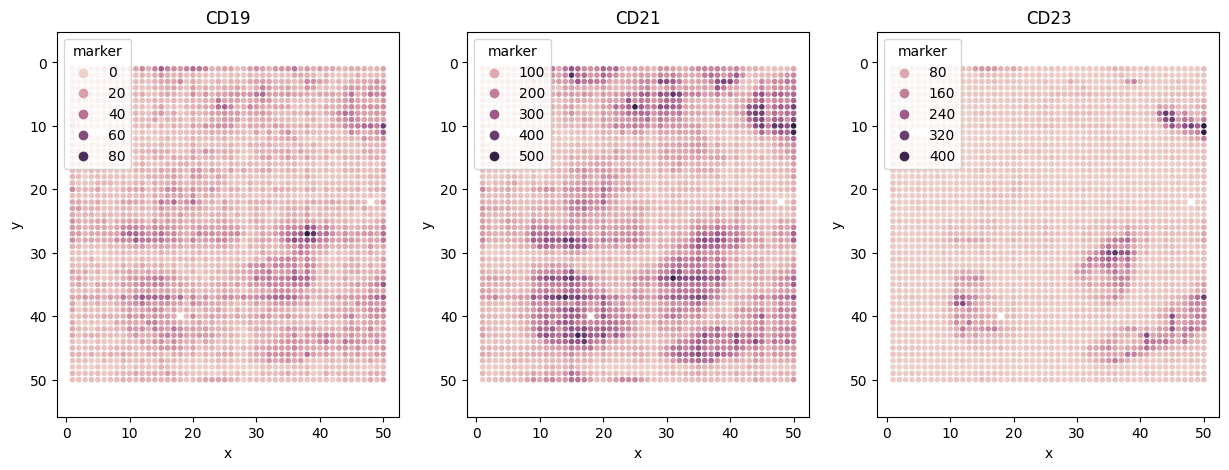

In [8]:
markers = ["CD19", "CD21", "CD23"]
fig, axs = plt.subplots(1, len(markers), figsize=(15, 5))
for i, marker in enumerate(markers):
    plot_df = coord.copy()
    plot_df["marker"] = prot[marker].to_numpy()
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[i], s=20)
    axs[i].axis('equal')
    axs[i].invert_yaxis()
    axs[i].set_title(marker)
plt.show()

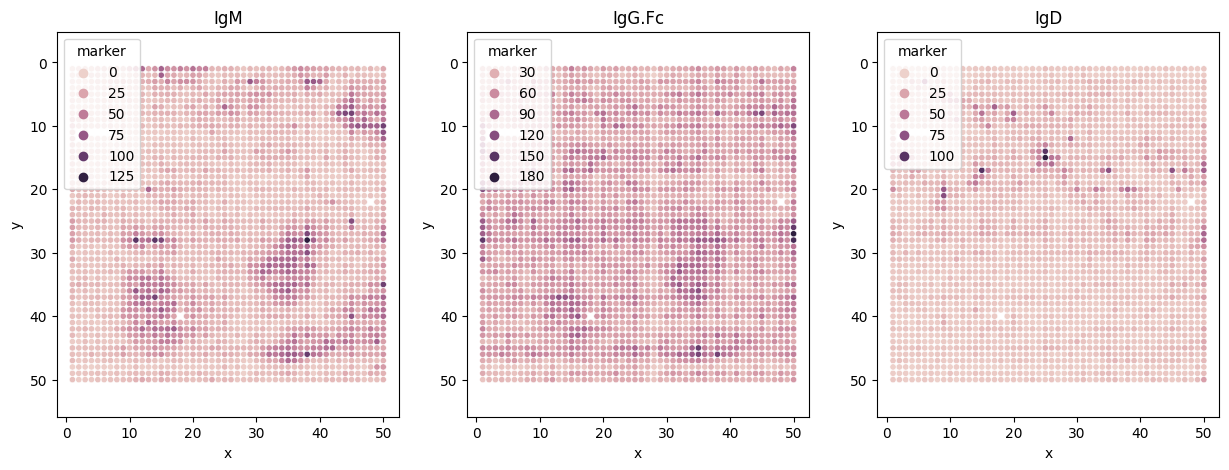

In [9]:
markers = ["IgM", "IgG.Fc", "IgD"]
fig, axs = plt.subplots(1, len(markers), figsize=(15, 5))
for i, marker in enumerate(markers):
    plot_df = coord.copy()
    plot_df["marker"] = prot[marker].to_numpy()
    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[i], s=20)
    axs[i].axis('equal')
    axs[i].invert_yaxis()
    axs[i].set_title(marker)
plt.show()

In [10]:
obs_df = rna.index.to_frame(name="name")
obs_df["x"] = coord["x"].to_numpy()
obs_df["y"] = coord["y"].to_numpy()
obs_df

,name,x,y
X,,,
29x42,29x42,29,42
44x36,44x36,44,36
34x6,34x6,34,6
42x19,42x19,42,19
41x6,41x6,41,6
...,...,...,...
2x26,2x26,2,26
30x26,30x26,30,26
23x48,23x48,23,48


In [11]:
spatial = obs_df.copy().loc[:, ["x", "y"]]
spatial

,x,y
X,,
29x42,29,42
44x36,44,36
34x6,34,6
42x19,42,19
41x6,41,6
...,...,...
2x26,2,26
30x26,30,26
23x48,23,48


In [12]:
rna_var = rna.columns.to_frame(name="gene")
rna_var.index = ["rna:" + str(i) for i in rna_var.index]
rna_var

,gene
rna:MIR1302.11,MIR1302.11
rna:OR4F5,OR4F5
rna:RP11.34P13.7,RP11.34P13.7
rna:AL627309.1,AL627309.1
rna:RP11.34P13.13,RP11.34P13.13
...,...
rna:AL592170.1,AL592170.1
rna:ENSG00000252127,ENSG00000252127
rna:AC145212.1,AC145212.1
rna:U6atac,U6atac


In [13]:
prot_var = prot.columns.to_frame(name="prot")
prot_var.index = ["prot:" + str(i) for i in prot_var.index]
prot_var

,prot
prot:CD64,CD64
prot:CD1d,CD1d
prot:CD270..HVEM_.TR2,CD270..HVEM_.TR2
prot:CD319..CRACC,CD319..CRACC
prot:CD34,CD34
...,...
prot:TNF.a,TNF.a
prot:CD215..IL.15Ra,CD215..IL.15Ra
prot:CD321,CD321
prot:HLA.DR_.DP_.DQ,HLA.DR_.DP_.DQ


In [14]:
rna_ad = ad.AnnData(X=rna.to_numpy(), var=rna_var, obs=obs_df, obsm={"spatial": spatial})
rna_ad

AnnData object with n_obs × n_vars = 2492 × 28388
    obs: 'name', 'x', 'y'
    var: 'gene'
    obsm: 'spatial'

In [15]:
prot_ad = ad.AnnData(X=prot.to_numpy(), var=prot_var, obs=obs_df, obsm={"spatial": spatial})
prot_ad

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2492 × 283
    obs: 'name', 'x', 'y'
    var: 'prot'
    obsm: 'spatial'

In [16]:
mdata = mu.MuData({"rna": rna_ad, "protein": prot_ad})
mdata

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:445: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


MuData object with n_obs × n_vars = 2492 × 28671
  2 modalities
    rna:	2492 x 28388
      obs:	'name', 'x', 'y'
      var:	'gene'
      obsm:	'spatial'
    protein:	2492 x 283
      obs:	'name', 'x', 'y'
      var:	'prot'
      obsm:	'spatial'

# RNA Analysis Only

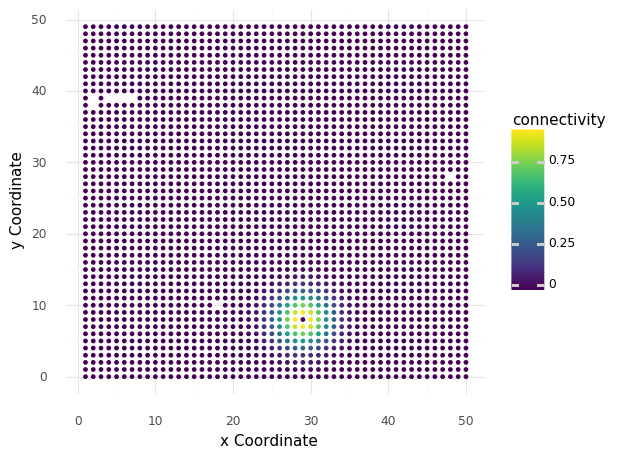

<ggplot: (703901594)>

In [17]:
li.ut.spatial_neighbors(mdata.mod["rna"], cutoff=0, bandwidth=2.5, set_diag=False)
li.pl.connectivity(mdata.mod["rna"], idx=0)

In [18]:
sc.pp.highly_variable_genes(mdata.mod["rna"])
hvg = mdata.mod["rna"].var[mdata.mod["rna"].var['highly_variable']].index

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:12: RuntimeWarning: overflow encountered in square
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:12: RuntimeWarning: invalid value encountered in subtract


In [25]:
hvg

Index(['rna:NOC2L', 'rna:TNFRSF4', 'rna:CPSF3L', 'rna:CCNL2', 'rna:MRPL20',
       'rna:ATAD3B', 'rna:SSU72', 'rna:CDK11B', 'rna:SLC35E2B', 'rna:NADK',
       ...
       'rna:MT.TV', 'rna:MT.TA', 'rna:MT.TN', 'rna:MT.ATP8', 'rna:MT.ND4L',
       'rna:MT.TH', 'rna:MT.ND6', 'rna:MT.TE', 'rna:MT.TP',
       'rna:ENSG00000215699'],
      dtype='object', length=2975)

In [19]:
sc.pp.normalize_total(mdata.mod["rna"], target_sum=1e4)
sc.pp.log1p(mdata.mod["rna"])

In [46]:
#li.rs.show_resources()
db = li.rs.select_resource("cellphonedb")
db

,ligand,receptor
13085,JAG2,NOTCH1
13086,DLL1,NOTCH1
13087,IGF1,IGF1R
13088,JAG1,NOTCH1
13089,WNT5A,FZD2
...,...,...
14303,WNT1,CD36
14304,OGN,HLA-DRB1
14305,CCL4L1,PGRMC2
14306,TNFSF9,KLRG2


In [58]:
ligands = np.unique(db.ligand.to_numpy())
receptors = np.unique(db.ligand.to_numpy())
genes = [x.split(":")[1] for x in mdata.mod["rna"].var_names]
proteins = [x.split(":")[1] for x in mdata.mod["protein"].var_names]

In [59]:
print(len(ligands))
print(len(receptors))

500
500


In [60]:
print(np.array([l in genes for l in ligands]).sum())
print(np.array([l in genes for l in receptors]).sum())

411
411


In [61]:
"CD270" in receptors

False

In [55]:
proteins

['CD64',
 'CD1d',
 'CD270..HVEM_.TR2',
 'CD319..CRACC',
 'CD34',
 'CD335..NKp46',
 'CD193..CCR3',
 'CD90..Thy1',
 'CD117..c.kit',
 'CD357..GITR',
 'CD70',
 'CD268..BAFF.R',
 'CD252..OX40L',
 'CD223..LAG.3',
 'CD304..Neuropilin.1',
 'CD184..CXCR4',
 'CD206..MMR',
 'LOX.1',
 'CD140b..PDGFRb',
 'CD269..BCMA',
 'CD267..TACI',
 'CD314..NKG2D',
 'TSLPR..TSLP.R',
 'CD257..BAFF_BLYS',
 'CD303..BDCA.2',
 'CD154',
 'CD273...B7.DC_.PD.L2',
 'CD274..B7.H1_.PD.L1',
 'CD80',
 'CD20',
 'b2.microglobulin',
 'CD99',
 'TCR.Va7.2',
 'HLA.E',
 'CD16',
 'CD307d..FcRL4',
 'CD137..4.1BB',
 'CD56',
 'CD307e..FcRL5',
 'CLEC12A',
 'CD36',
 'CD81..TAPA.1',
 'CD40',
 'CD137L..4.1BB.Ligand',
 'CD66b',
 'CD328..Siglec.7',
 'CD324..E.Cadherin',
 'TCR.Va24.Ja18..iNKT.cell',
 'CD123',
 'CD169..Sialoadhesin_Siglec.1',
 'GARP..LRRC32',
 'CD204',
 'CD309..VEGFR2',
 'CD370..CLEC9A_DNGR1',
 'CD326..Ep.CAM',
 'CD209..DC.SIGN',
 'CD49d',
 'CD127..IL.7Ra',
 'CD39',
 'CD150..SLAM',
 'TIGIT..VSTM3',
 'CD73..Ecto.5..nucleotidase

In [54]:
print(np.array([l in proteins for l in ligands]).sum())
print(np.array([l in proteins for l in receptor]).sum())

8
8


In [ ]:
orig_names

In [250]:
# Appendix
print(np.array([s in gene_annot["Gene name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot["HGNC symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot["UniProtKB Gene Name symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot["WikiGene name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())

print(np.array([s in gene_annot_2["Approved symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot_2["Approved name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot_2["Previous symbols"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
print(np.array([s in gene_annot_2["Aliases"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())